# Methodology

We follow a machine learning approach as exemplified in the original github.com package. Nonetheless, the initial experimentation was performed using time series algorithms as autoregressive integrated moving average (ARIMA) and autoregressive moving average (ARMA). However, the package used to create these models could not produce a model for each Country, and particular transformations were needed for each case to obtain a satisfactory ARIMA or ARMA model; given the amount of work, we decided to abandon this path and go straight to the approach described in the package examples, particular in the linear one. 

## Data transformation

The first step was to transform the data into the format required by most algorithms implemented in the scikit-learn package.

In [21]:
from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn import metrics
from tqdm import tqdm
# NixtamalAI's packages
from covid_xprize.nixtamalai.helpers import ID_COLS
from covid_xprize.nixtamalai import helpers
from covid_xprize.nixtamalai import models

In [22]:
# Getting de data
data = helpers.preprocess_full()            

### Comparing the performance of the two versions of the number of cases

In [23]:
population = {k:v for k, v in data.groupby("GeoID").Population.last().items()}

def predict(data, trans, model, start_date="2020-11-13", end_date="2020-12-05"):
    output = defaultdict(list)
    for X in trans.transform(data, start=start_date, end=end_date):
        hy = trans.update_prediction(model.predict(X))
        key = X.iloc[0]["GeoID"]
        output[key].append(hy)
    geo_pred_dfs = list()
    start_date = pd.to_datetime(start_date, format='%Y-%m-%d')
    end_date = pd.to_datetime(end_date, format='%Y-%m-%d')    
    data = data[(data.Date >= start_date) & (data.Date <= end_date)].copy()
    for key, value in output.items():
        geo_pred_df = data.loc[data.GeoID == key, ID_COLS].copy()
        # print(len(value), geo_pred_df.shape, key)
        geo_pred_df['PredictedDailyNewCases'] = value[-geo_pred_df.shape[0]:]
        geo_pred_dfs.append(geo_pred_df)
    pred_df = pd.concat(geo_pred_dfs)
    return pred_df

def performance(output):
    res = pd.merge(data, output, how="inner")
    y = res.NewCasesHampel.rolling(7, min_periods=1).mean()
    hy = res.PredictedDailyNewCases.rolling(7, min_periods=1).mean()
    mae = metrics.mean_absolute_error(y, hy)

    _ = [((100000 * value.NewCasesHampel /  population[key]).rolling(7, min_periods=1).mean().to_numpy(),
          (100000 * value.PredictedDailyNewCases /  population[key]).rolling(7, min_periods=1).mean().to_numpy())
         for key, value in res.groupby("GeoID")]

    y = np.concatenate([x[0] for x in _])
    hy = np.concatenate([x[1] for x in _])
    return [mae, metrics.mean_absolute_error(y, hy)]

The dataset is a matrix of the exogenous variables and the number of cases, each using thirty lags. Regarding the number of cases, we observed two approaches: to use the raw number, and the other is to transform it into cases per 100,000 individuals. 

In [ ]:
# Number of cases
trans = models.Features().fit(data)
# Number of cases per 100000
transN = models.FeaturesN().fit(data)

In [ ]:
# Creating the models
HY = []
for t in [trans, transN]:
    X, y = t.training_set()
    m = models.AR().fit(X, y)
    _ = predict(data, t, m)
    HY.append(_)

In [ ]:
# Performance MAE [Number of cases, Number of cases per 100000]
for hy in HY:
    _ = performance(hy)
    print(["%0.4f" %x for x in _])

### Performance of the number of lags

In [31]:
# Predictions when the number of lags are varied from:
lags = [2, 4, 8, 16, 32, 64]
HY = []
for lag in tqdm(lags):
    transN = models.FeaturesN(lags=lag).fit(data)
    X, y = transN.training_set()
    m = models.AR().fit(X, y)
    _ = predict(data, transN, m)
    HY.append(_)

100%|██████████| 6/6 [13:18<00:00, 133.11s/it]


In [34]:
D = []
for hy in HY:
    D.append({k: v for k, v in zip(["MAE", "Norm. MAE"], performance(hy))})
perf = pd.DataFrame(D, index=lags)

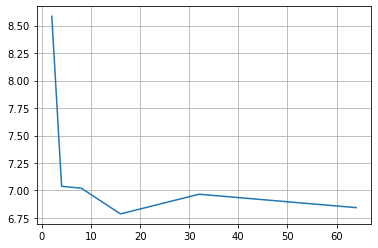

In [39]:
perf.loc[:, "Norm. MAE"].plot(grid=True)

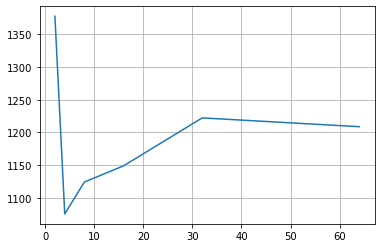

In [40]:
perf.loc[:, "MAE"].plot(grid=True)

In [30]:
transN._lags

64